# Flipkart Laptop Review Topic Modeling

In [27]:
# Import Library
import os
import numpy as np
import pandas as pd
import random
import spacy
import kagglehub
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score 
from sklearn.manifold import TSNE 
import matplotlib.cm as cm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from bertopic import BERTopic
from gensim import corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.coherencemodel import CoherenceModel
from collections import Counter
import matplotlib.pyplot as plt


RANDOM_STATE = 555
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)


# Data Collection and Preprocessing
- Collect relevant datasets.
- Preprocess the text data that will involve different NLP tasks where needed.
- Split the dataset into a training set and a test set.


In [28]:
# Download latest version
path = kagglehub.dataset_download("gitadityamaddali/flipkart-laptop-reviews")
df = pd.read_csv(os.path.join(path, "laptops_dataset_final_600.csv"))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24113 entries, 0 to 24112
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_name    24113 non-null  object 
 1   overall_rating  24113 non-null  float64
 2   no_ratings      24113 non-null  object 
 3   no_reviews      24113 non-null  object 
 4   rating          24113 non-null  int64  
 5   title           24113 non-null  object 
 6   review          24113 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.3+ MB


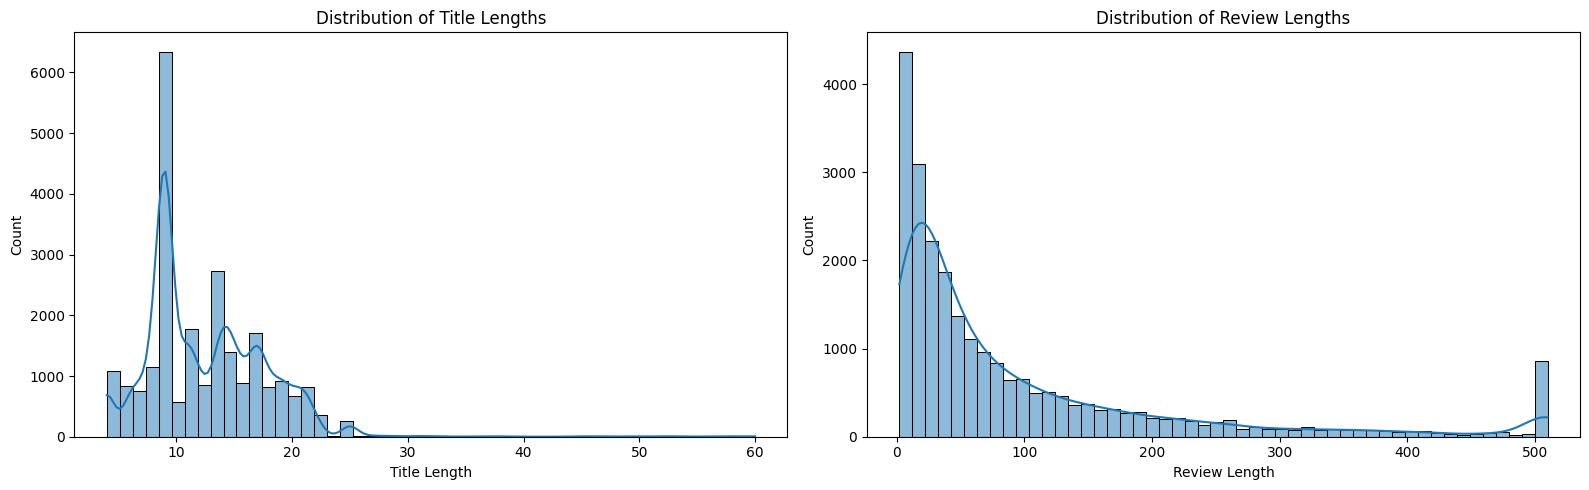

In [29]:
# Exploratory Data Analysis
df['title_length'] = df['title'].apply(len)
df['review_length'] = df['review'].apply(len)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(df['title_length'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Title Lengths')
ax[0].set_xlabel('Title Length')

sns.histplot(df['review_length'], bins=50, kde=True, ax=ax[1])
ax[1].set_title('Distribution of Review Lengths')
ax[1].set_xlabel('Review Length') 

plt.tight_layout()
plt.show()


In [30]:
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

# Get the default stop words
default_stops = nlp.Defaults.stop_words

# Remove negation words from stop words
negation_words = {'no', 'not', 'nor', 'neither', 'never', "n't", "ain't", "aren't", 
                 "can't", "couldn't", "didn't", "doesn't", "don't", "hasn't", 
                 "haven't", "isn't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't"}

# domain_specific = {'laptop', 'product', 'battery', 'display', 'performance','quality','price'}

# Remove negation words from stop words
custom_stop_words = default_stops - negation_words
def preprocess_text(text: str) -> str:
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.lemma_.lower() not in custom_stop_words and 
                                                    #    token.lemma_.lower() not in domain_specific and
                                                                            not token.is_stop and 
                                                                            not token.is_digit and
                                                                            not token.is_space and 
                                                                            not token.is_quote and
                                                                            not token.is_punct]
    return " ".join(tokens)
 
df['combined_text'] = df['title'] + " " + df['review']
df['combined_processed'] = df['combined_text'].apply(preprocess_text)

# Remove duplicate reviews
print(len(df))
df = df.drop_duplicates(subset=['combined_processed'])
print(len(df))

# Drop unused columns
df.drop(columns=['title', 
                 'review',
                 'title_length', 
                 'review_length'], inplace=True, errors='ignore')


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/nlp/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/nlp/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
_pickle.UnpicklingError: pickle data was truncated


24113
11673


## Feature Extraction and Feature Engineering
- Extract and select numerical features from text data using NLP techniques - Bag of Words (BoW), TF-IDF, or word embeddings (Word2Vec, GloVe).

In [31]:
min_count = len(df['combined_processed']) * 0.0002
threshold = len(df['combined_processed']) * 0.01

print(min_count, threshold)
# Create a list of tokenized documents
tokenized_docs = [doc.split() for doc in df['combined_processed']]

# Create bigram model
bigram = Phrases(tokenized_docs, min_count=min_count, threshold=threshold)  
bigram_mod = Phraser(bigram) 

# Create trigram model
trigram = Phrases(bigram_mod[tokenized_docs], min_count=min_count, threshold=threshold)  
trigram_mod = Phraser(trigram)

# Transform the documents with bigrams into documents with trigrams
docs_bigrams = [bigram_mod[doc] for doc in tokenized_docs]
docs_trigrams = [trigram_mod[bigram_mod[doc]] for doc in tokenized_docs]

# Create a dictionary and corpus
dictionary = corpora.Dictionary(docs_trigrams)
dictionary.filter_extremes(no_below=2, no_above=0.7)

corpus = [dictionary.doc2bow(doc) for doc in docs_trigrams]

# Create a list of trigram-based documents
docs_trigrams_text = [' '.join(doc) for doc in docs_trigrams]

2.3346 116.73


In [32]:
# BoW - for LDA model
bow_vectorizer = CountVectorizer(min_df=5, max_df=0.5)
bow_vectors = bow_vectorizer.fit_transform(docs_trigrams_text)
print(bow_vectors.shape)

# TF-IDF- for NMF model
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.5)
tfidf_vectors = tfidf_vectorizer.fit_transform(docs_trigrams_text)
print(tfidf_vectors.shape)

# documents for BERTopic model
docs_bert = docs_trigrams_text

(11673, 1765)
(11673, 1765)


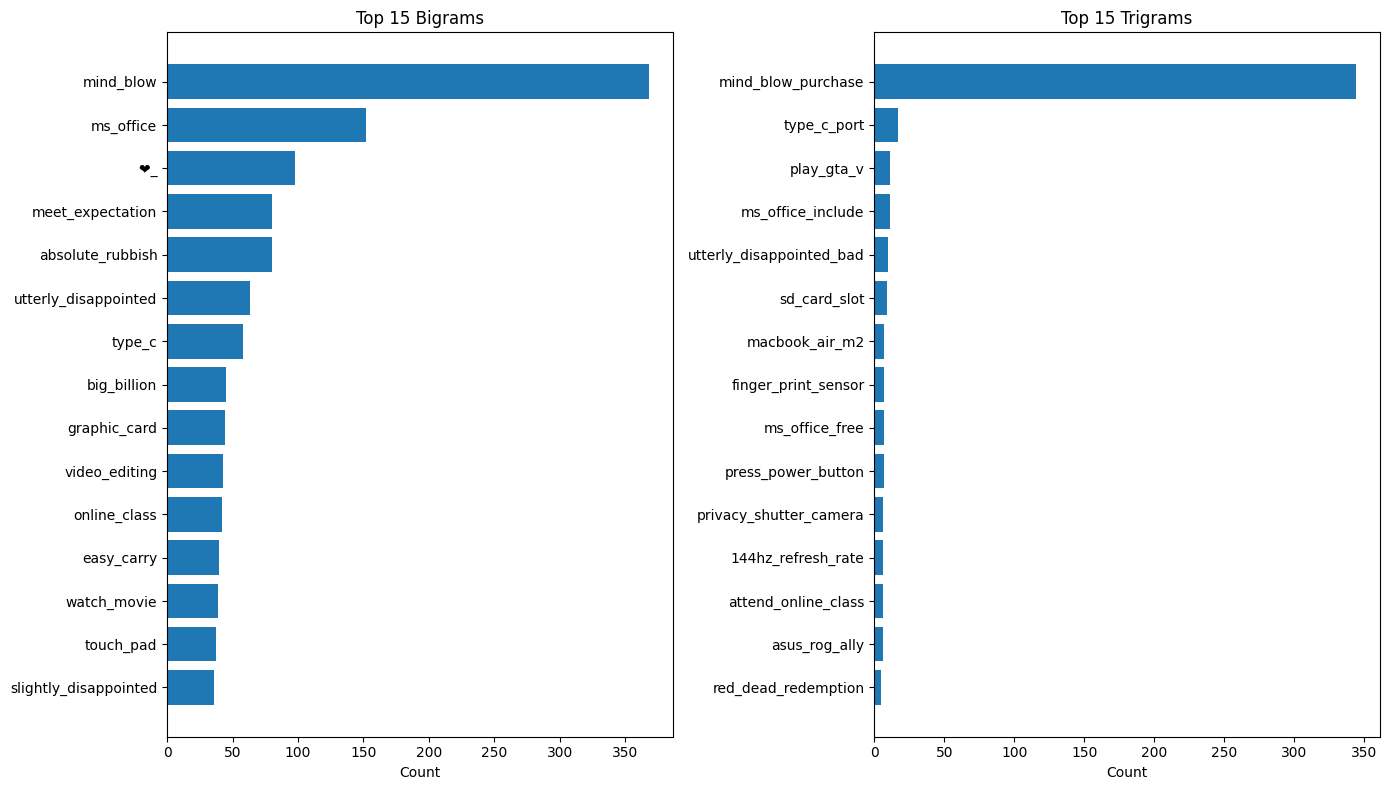

In [33]:
# Display the most common bigrams and trigrams
bigram_phrases = []
# Get the most common bigrams from the tokenized documents
bigram_counter = Counter()
for doc in docs_bigrams:
    for i in range(len(doc) - 1):
        if '_' in doc[i]:  # This is a bigram
            bigram_counter[doc[i]] += 1

# Get top 20 bigrams
top_bigrams = bigram_counter.most_common(20)
# print("\nMost common trigrams:")
trigram_counter = Counter()
for doc in docs_trigrams:
    for token in doc:
        if token.count('_') == 2:  # This is a trigram
            trigram_counter[token] += 1

# Get top 20 trigrams
top_trigrams = trigram_counter.most_common(20)
# Visualize top bigrams and trigrams
plt.figure(figsize=(14, 8))

# Plot bigrams
plt.subplot(1, 2, 1)
bigram_words, bigram_counts = zip(*top_bigrams[:15]) if top_bigrams else ([], [])
bigram_words = bigram_words[::-1]
bigram_counts = bigram_counts[::-1]
plt.barh(range(len(bigram_words)), bigram_counts, align='center')
plt.yticks(range(len(bigram_words)), bigram_words)
plt.title('Top 15 Bigrams')
plt.xlabel('Count')

# Plot trigrams
plt.subplot(1, 2, 2)
trigram_words, trigram_counts = zip(*top_trigrams[:15]) if top_trigrams else ([], [])
trigram_words = trigram_words[::-1]
trigram_counts = trigram_counts[::-1]
plt.barh(range(len(trigram_words)), trigram_counts, align='center')
plt.yticks(range(len(trigram_words)), trigram_words)
plt.title('Top 15 Trigrams')
plt.xlabel('Count')

plt.tight_layout()
plt.show()


## Model Training and Evaluation
- Train the model on the training dataset.
- Evaluate the model using appropriate metrics:
  - Classification: Accuracy, Precision, Recall, F1-Score.
  - Topic Modeling: Perplexity, Topic Coherence.
- Fine-tune model parameters for optimal performance.


In [34]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_components': [2, 3, 5, 7],  # Number of topics
    'learning_decay': [0.5, 0.9],  # Controls learning rate decay
    'doc_topic_prior': [0.01, 0.1, 0.5, 1.0],  # Alpha parameter
    'topic_word_prior': [0.01, 0.1, 0.5, 1.0],  # Beta parameter
    'learning_offset': [10, 50]  # A downweighting factor
}

# Grid search
grid_lda = GridSearchCV(
    LatentDirichletAllocation(learning_method='online', 
                              random_state=RANDOM_STATE,),
    param_grid=params,
    n_jobs=-1,
    verbose=2,
)

grid_lda.fit(bow_vectors)

# Best parameters
print("Best Parameters from HyperParameter tuning")
print(grid_lda.best_params_)
best_lda = grid_lda.best_estimator_

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


2710.61s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2710.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2710.66s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2710.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2710.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2710.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2710.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2710.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2710.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2710.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2710.73s - pydevd: Sending message related to proc

[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=2, topic_word_prior=0.01; total time=   3.1s
[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=2, topic_word_prior=0.1; total time=   3.1s
[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=2, topic_word_prior=0.01; total time=   3.1s
[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=2, topic_word_prior=0.01; total time=   3.1s
[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=2, topic_word_prior=0.1; total time=   3.1s
[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=2, topic_word_prior=0.1; total time=   3.1s
[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=2, topic_word_prior=0.1; total time=   3.2s
[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=2, topic_word_pri

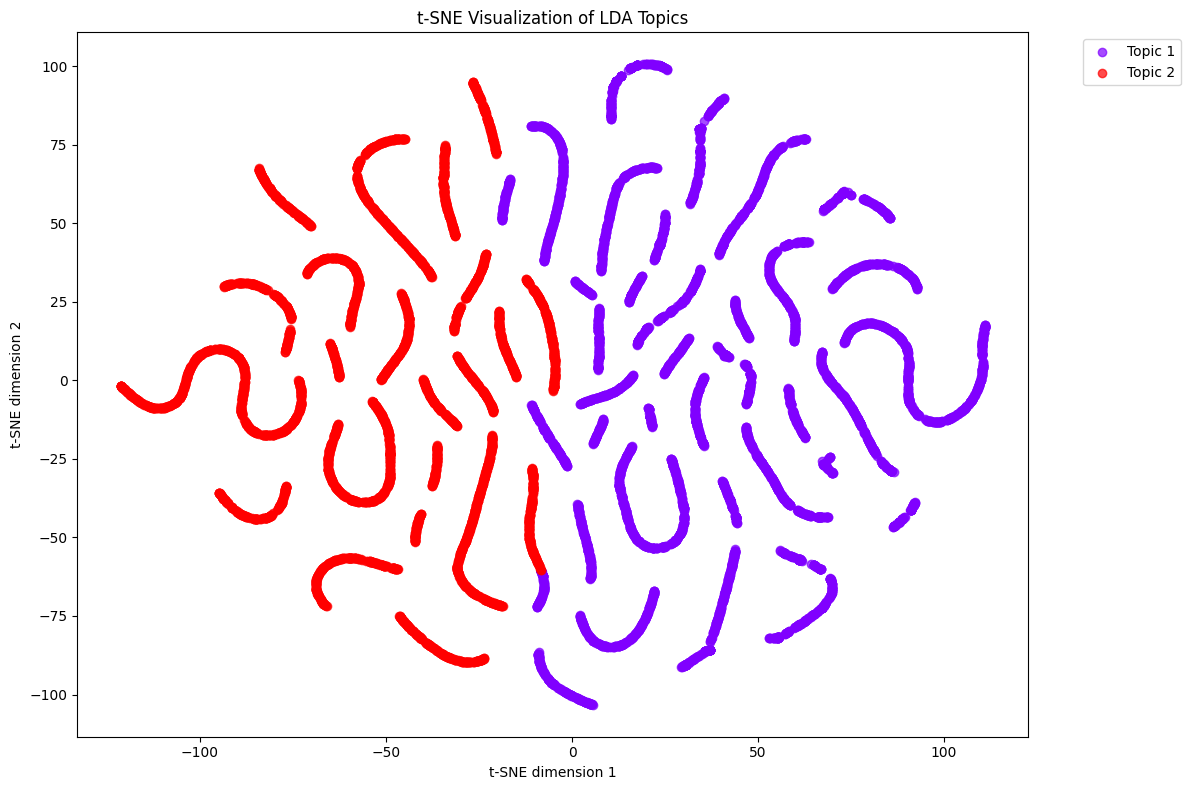

In [35]:
# Transform the data
lda_output = best_lda.transform(bow_vectors)

# Create t-SNE model
tsne = TSNE(n_components=2, 
            random_state=RANDOM_STATE, 
            perplexity=30, 
            max_iter=1000, 
            n_jobs=-1)

tsne_results = tsne.fit_transform(lda_output)

# Create a scatter plot
plt.figure(figsize=(12, 8))
colors = cm.rainbow(np.linspace(0, 1, grid_lda.best_params_['n_components']))

# Get the dominant topic for each document
dominant_topics = np.argmax(lda_output, axis=1)

# Plot each document colored by its dominant topic
for topic_idx in range(grid_lda.best_params_['n_components']):
    # Get indices of documents with this dominant topic
    indices = np.where(dominant_topics == topic_idx)[0]
    plt.scatter(
        tsne_results[indices, 0], 
        tsne_results[indices, 1],
        c=[colors[topic_idx]],
        label=f'Topic {topic_idx+1}',
        alpha=0.7
    )

plt.title('t-SNE Visualization of LDA Topics')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import gensim

def get_top_words(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
    return topics

# Create the dictionary from the same vectorizer used for LDA
feature_names = bow_vectorizer.get_feature_names_out()
id2word = {i: word for i, word in enumerate(feature_names)}
dictionary = gensim.corpora.Dictionary.from_corpus(
    gensim.matutils.Sparse2Corpus(bow_vectors, documents_columns=False),
    id2word=id2word
)

lda_top_words = get_top_words(best_lda, feature_names)
print(docs_trigrams_text)
print('--------------------------------')
print(lda_top_words)
print('--------------------------------')
print(dictionary)
lda_coherence_model = CoherenceModel(topics=lda_top_words, 
                                     texts=docs_trigrams_text,
                                     dictionary=dictionary, 
                                     coherence='c_v')
lda_coherence = lda_coherence_model.get_coherence()
print(f"LDA Coherence Score (C_V): {lda_coherence:.4f}")
 
perplexity = best_lda.perplexity(bow_vectors)
print(f"Perplexity: {perplexity:.4f}")

silhouette = silhouette_score(lda_output, np.argmax(lda_output, axis=1))
print(f"Silhouette: {silhouette:.4f}")


TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [8]:
# Function to evaluate different numbers of topics
def evaluate_lda_topics(min_topics=2, max_topics=10, step=1):
    topics_range = range(min_topics, max_topics + 1, step)
    perplexity_scores = []
    silhouette_scores = []
    
    # Evaluate each topic number
    for num_topics in topics_range:
        lda = LatentDirichletAllocation(
            n_components=num_topics,
            learning_method='online',
            random_state=RANDOM_STATE
        )
        lda_output = lda.fit_transform(bow_vectors)
        
        # Calculate metrics
        perplexity = lda.perplexity(bow_vectors)
        perplexity_scores.append(perplexity)
         
        # Calculate silhouette score
        silhouette = calculate_silhouette(lda, bow_vectors)
        silhouette_scores.append(silhouette)
        
        print(f"Number of topics: {num_topics} | Perplexity: {perplexity:.4f} | Silhouette: {silhouette:.4f}")
    
    return topics_range, perplexity_scores, silhouette_scores

def calculate_silhouette(lda, X):
    lda_output = lda.transform(X)
    return silhouette_score(lda_output, np.argmax(lda_output, axis=1))

topics_range, perplexity_scores, silhouette_scores = evaluate_lda_topics()

best_num_topics = topics_range[np.argmin(perplexity_scores)]
print(f"Best number of topics: {best_num_topics}")
print(f"Perplexity: {perplexity_scores[np.argmin(perplexity_scores)]}")
print(f"Silhouette: {silhouette_scores[np.argmin(perplexity_scores)]}")


Number of topics: 2 | Perplexity: 377.2522 | Silhouette: 0.6712
Number of topics: 3 | Perplexity: 381.2989 | Silhouette: 0.5357
Number of topics: 4 | Perplexity: 397.1941 | Silhouette: 0.4535
Number of topics: 5 | Perplexity: 405.1779 | Silhouette: 0.3900
Number of topics: 6 | Perplexity: 421.4485 | Silhouette: 0.3736
Number of topics: 7 | Perplexity: 427.5043 | Silhouette: 0.3548
Number of topics: 8 | Perplexity: 437.1165 | Silhouette: 0.3287
Number of topics: 9 | Perplexity: 438.7379 | Silhouette: 0.3154
Number of topics: 10 | Perplexity: 450.4070 | Silhouette: 0.3143
Best number of topics: 2
Perplexity: 377.2521531279286
Silhouette: 0.6712028837247801


In [54]:
lda = LatentDirichletAllocation(
    n_components=best_num_topics,
    learning_method='online',
    random_state=RANDOM_STATE
)
lda.fit(bow_vectors)

LatentDirichletAllocation(learning_method='online', n_components=2,
                          random_state=555)

In [50]:
print(dictionary)

Dictionary<5298 unique tokens: ['earn', 'hardwork', 'love', 'macbook', 'perfect']...>


In [55]:
def get_top_words(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
    return topics

lda_top_words = get_top_words(lda, bow_vectorizer.get_feature_names_out())
print(lda_top_words)
lda_coherence_model = CoherenceModel(topics=lda_top_words, 
                                     texts=docs_trigrams_text,
                                     dictionary=dictionary, 
                                     coherence='c_v')
lda_coherence = lda_coherence_model.get_coherence()
print(f"LDA Coherence Score (C_V): {lda_coherence:.4f}")


[['laptop', 'battery', 'display', 'performance', 'work', 'quality', 'backup', 'use', 'bad', 'buy'], ['product', 'nice', 'laptop', 'money', 'value', 'awesome', 'purchase', 'price', 'worth', 'great']]
LDA Coherence Score (C_V): nan


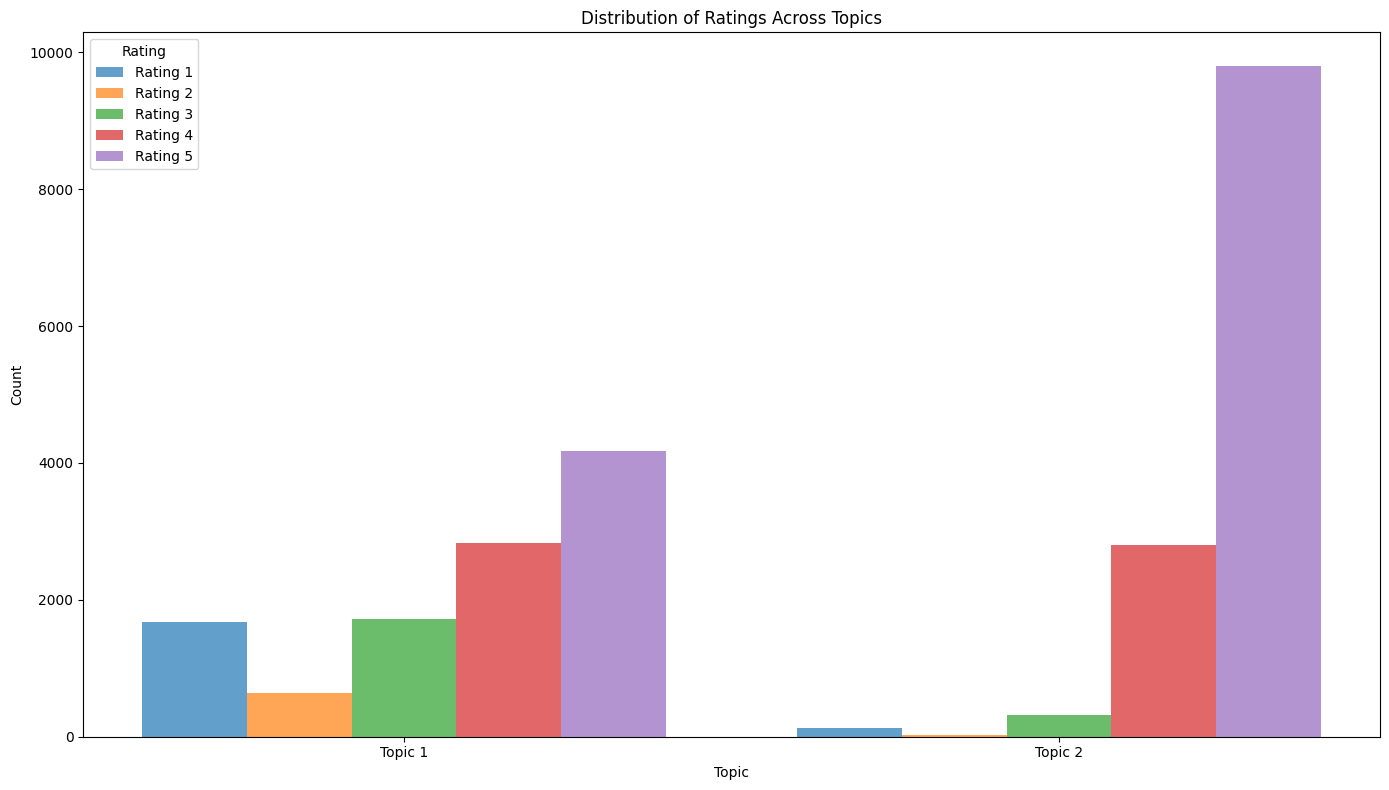

In [56]:
# Get the dominant topic for each document
lda_output = lda.transform(bow_vectors)
dominant_topics = np.argmax(lda_output, axis=1)

# Get the ratings for each document
ratings = df['rating'].values

# Create a figure for the bar chart
plt.figure(figsize=(14, 8))

# Define the rating categories
rating_categories = sorted(df['rating'].unique())

# Create a dictionary to store counts for each topic and rating
topic_rating_counts = {}
for topic_idx in range(best_num_topics):
    topic_rating_counts[topic_idx] = {}
    for rating in rating_categories:
        # Count documents with this topic and rating
        count = np.sum((dominant_topics == topic_idx) & (ratings == rating))
        topic_rating_counts[topic_idx][rating] = count

# Set up the bar chart
bar_width = 0.8 / len(rating_categories)
x = np.arange(best_num_topics)

# Plot bars for each rating category
for i, rating in enumerate(rating_categories):
    counts = [topic_rating_counts[topic_idx][rating] for topic_idx in range(best_num_topics)]
    plt.bar(x + i * bar_width, counts, width=bar_width, 
            label=f'Rating {rating}', alpha=0.7)

# Add labels and title
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Distribution of Ratings Across Topics')
plt.xticks(x + bar_width * (len(rating_categories) - 1) / 2, 
           [f'Topic {i+1}' for i in range(best_num_topics)])
plt.legend(title='Rating')
plt.tight_layout()
plt.show()


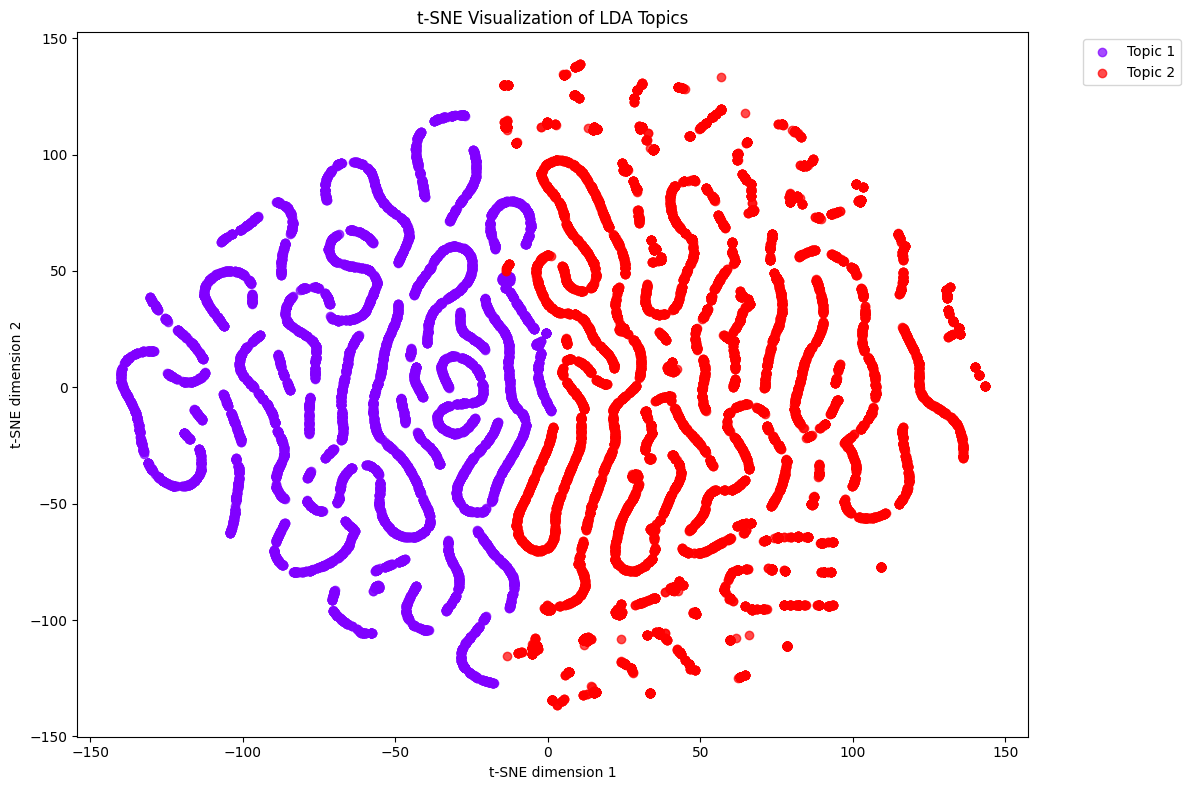

In [57]:
# Transform the data
lda_output = lda.transform(bow_vectors)

# Create t-SNE model
tsne = TSNE(n_components=2, 
            random_state=RANDOM_STATE, 
            perplexity=30, 
            max_iter=1000, 
            n_jobs=-1)

tsne_results = tsne.fit_transform(lda_output)

# Create a scatter plot
plt.figure(figsize=(12, 8))
colors = cm.rainbow(np.linspace(0, 1, best_num_topics))

# Get the dominant topic for each document
dominant_topics = np.argmax(lda_output, axis=1)

# Plot each document colored by its dominant topic
for topic_idx in range(best_num_topics):
    # Get indices of documents with this dominant topic
    indices = np.where(dominant_topics == topic_idx)[0]
    plt.scatter(
        tsne_results[indices, 0], 
        tsne_results[indices, 1],
        c=[colors[topic_idx]],
        label=f'Topic {topic_idx+1}',
        alpha=0.7
    )

plt.title('t-SNE Visualization of LDA Topics')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Model Refinement and Optimization
- Experiment with different autoencoder architectures, hyperparameters, and reconstruction error thresholds to fine-tune the model's performance.
- Apply techniques such as learning rate scheduling, regularization, and dropout to improve the model's generalization and robustness.


1. Hyperparameter Tuning using grid-search.
2. Use NMF for topic modeling.

In [59]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_components': [2, 3, 5, 7],  # Number of topics
    'learning_decay': [0.5, 0.9],  # Controls learning rate decay
    'doc_topic_prior': [0.01, 0.1, 0.5, 1.0],  # Alpha parameter
    'topic_word_prior': [0.01, 0.1, 0.5, 1.0],  # Beta parameter
    'learning_offset': [10, 50]  # A downweighting factor
}

# Grid search
grid_lda = GridSearchCV(
    LatentDirichletAllocation(learning_method='online', 
                              random_state=RANDOM_STATE,),
    param_grid=params,
    n_jobs=-1,
    verbose=2,
)

grid_lda.fit(bow_vectors)

# Best parameters
print("Best Parameters from HyperParameter tuning")
print(grid_lda.best_params_)
best_lda = grid_lda.best_estimator_

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=3, topic_word_prior=0.01; total time=   7.3s
[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=3, topic_word_prior=0.01; total time=   7.3s
[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=3, topic_word_prior=0.01; total time=   7.4s
[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=3, topic_word_prior=0.1; total time=   7.4s
[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=3, topic_word_prior=0.1; total time=   7.5s
[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=3, topic_word_prior=0.01; total time=   7.5s
[CV] END doc_topic_prior=0.01, learning_decay=0.5, learning_offset=10, n_components=3, topic_word_prior=0.01; total time=   7.5s
[CV] END doc_topic_prior=0.01, learn

In [60]:
# Print the top 10 words for each topic
feature_names = bow_vectorizer.get_feature_names_out()
n_top_words = 10

print(f"Top {n_top_words} words for each topic:")
for topic_idx, topic in enumerate(best_lda.components_):
    # Sort the terms by their importance in this topic
    top_features_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [(feature_names[i], topic[i]) for i in top_features_idx]
    
    # Print topic number and the top words with their scores
    print(f"\nTopic {topic_idx + 1}:")
    for word, score in top_features:
        print(f"  {word}: {score:.4f}")

Top 10 words for each topic:

Topic 1:
  battery: 5036.7070
  display: 2595.5725
  work: 2468.8101
  quality: 1847.7980
  performance: 1555.7292
  backup: 1552.5610
  bad: 1517.0340
  use: 1501.3938
  gaming: 1242.3312
  issue: 1218.4470

Topic 2:
  product: 11125.9310
  nice: 4623.5821
  money: 4217.5349
  value: 2788.9925
  purchase: 2256.1025
  great: 1715.6280
  terrific: 1680.1354
  excellent: 1654.8038
  wonderful: 1422.1747
  super: 1375.9315

Topic 3:
  laptop: 9432.1339
  price: 2788.3177
  awesome: 2683.3455
  buy: 2571.3550
  worth: 1960.1393
  performance: 1463.4789
  recommend: 1338.3600
  look: 1107.7992
  range: 1058.1292
  flipkart: 1051.3761


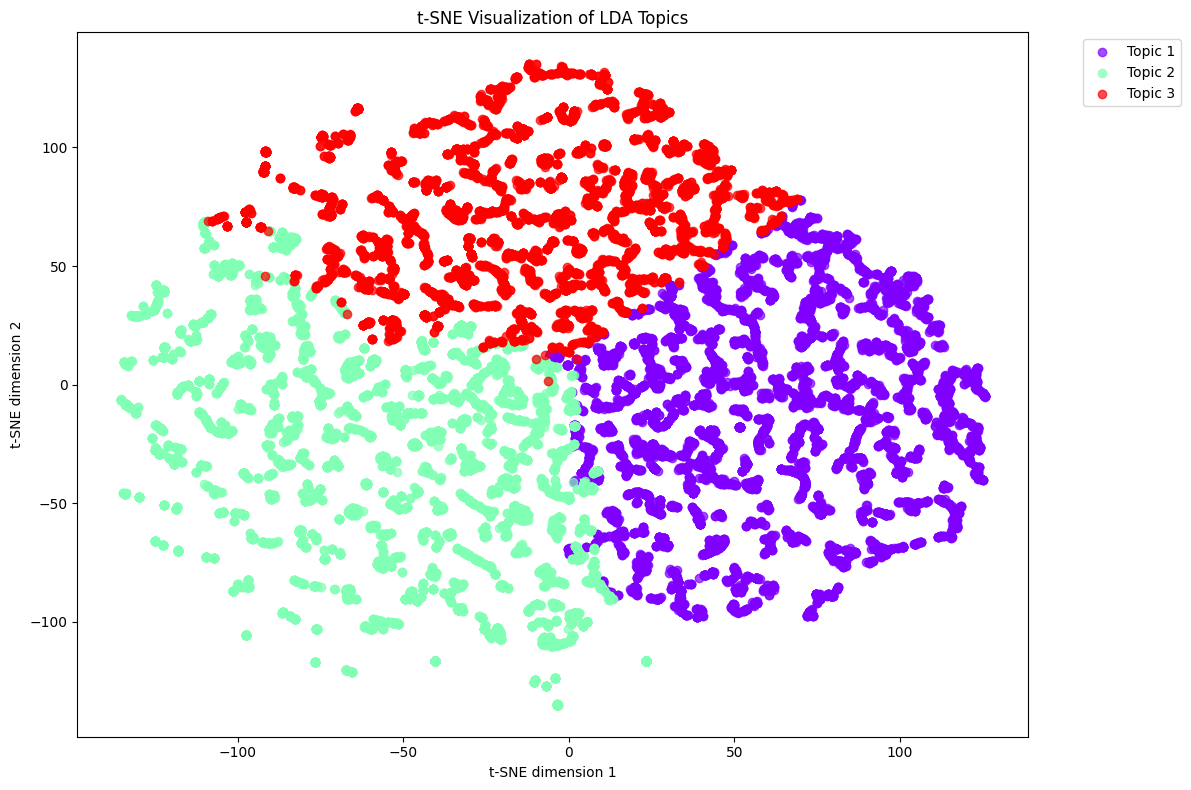

In [62]:
best_num_topics = 3

# Transform the data
lda_output = best_lda.transform(bow_vectors)

# Create t-SNE model
tsne = TSNE(n_components=2, 
            random_state=RANDOM_STATE, 
            perplexity=30, 
            max_iter=1000, 
            n_jobs=1)

tsne_results = tsne.fit_transform(lda_output)

# Create a scatter plot
plt.figure(figsize=(12, 8))
colors = cm.rainbow(np.linspace(0, 1, best_num_topics))

# Get the dominant topic for each document
dominant_topics = np.argmax(lda_output, axis=1)

# Plot each document colored by its dominant topic
for topic_idx in range(best_num_topics):
    # Get indices of documents with this dominant topic
    indices = np.where(dominant_topics == topic_idx)[0]
    plt.scatter(
        tsne_results[indices, 0], 
        tsne_results[indices, 1],
        c=[colors[topic_idx]],
        label=f'Topic {topic_idx+1}',
        alpha=0.7
    )

plt.title('t-SNE Visualization of LDA Topics')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

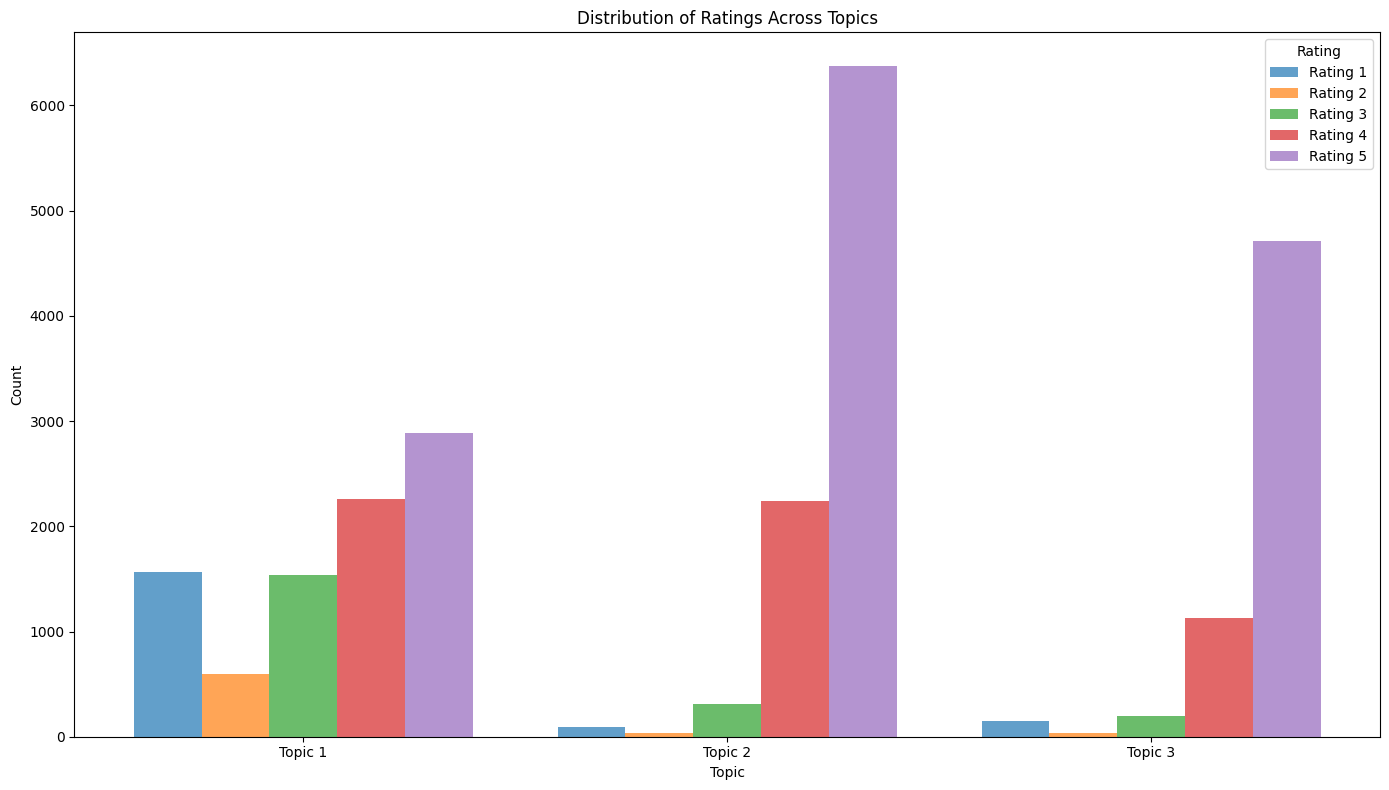

In [63]:
# Get the dominant topic for each document
lda_output = best_lda.transform(bow_vectors)
dominant_topics = np.argmax(lda_output, axis=1)

# Get the ratings for each document
ratings = df['rating'].values

# Create a figure for the bar chart
plt.figure(figsize=(14, 8))

# Define the rating categories
rating_categories = sorted(df['rating'].unique())

# Create a dictionary to store counts for each topic and rating
topic_rating_counts = {}
for topic_idx in range(best_num_topics):
    topic_rating_counts[topic_idx] = {}
    for rating in rating_categories:
        # Count documents with this topic and rating
        count = np.sum((dominant_topics == topic_idx) & (ratings == rating))
        topic_rating_counts[topic_idx][rating] = count

# Set up the bar chart
bar_width = 0.8 / len(rating_categories)
x = np.arange(best_num_topics)

# Plot bars for each rating category
for i, rating in enumerate(rating_categories):
    counts = [topic_rating_counts[topic_idx][rating] for topic_idx in range(best_num_topics)]
    plt.bar(x + i * bar_width, counts, width=bar_width, 
            label=f'Rating {rating}', alpha=0.7)

# Add labels and title
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Distribution of Ratings Across Topics')
plt.xticks(x + bar_width * (len(rating_categories) - 1) / 2, 
           [f'Topic {i+1}' for i in range(best_num_topics)])
plt.legend(title='Rating')
plt.tight_layout()
plt.show()


In [65]:
nmf_model = NMF(n_components=best_num_topics, random_state=RANDOM_STATE)
W = nmf_model.fit_transform(tfidf_vectors)  # Document-topic matrix
H = nmf_model.components_      # Topic-term matrix

silhouette = silhouette_score(tfidf_vectors.toarray(), np.argmax(W, axis=1))
print(f"Silhouette Score: {silhouette:.4f}") # Document-topic matrix

def nmf_pseudo_perplexity(X, W, H):
    # Reconstruction
    X_reconstructed = W @ H
    
    # Calculate error (lower is better)
    reconstruction_error = np.mean((X.toarray() - X_reconstructed) ** 2)
    
    # Pseudo-perplexity (lower is better)
    pseudo_perplexity = np.exp(reconstruction_error)
    return pseudo_perplexity

perplexity = nmf_pseudo_perplexity(tfidf_vectors, W, nmf_model.components_)
print(f"Pseudo-Perplexity: {perplexity:.4f}")

Silhouette Score: 0.0236
Pseudo-Perplexity: 1.0004


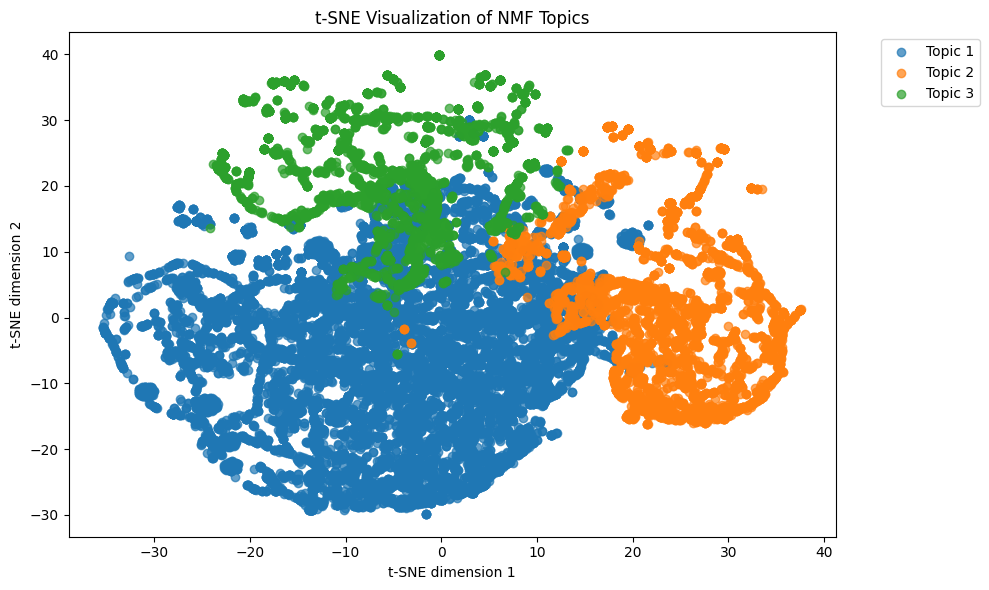

In [66]:
# Apply t-SNE to NMF document-topic matrix
tsne_nmf = TSNE(n_components=best_num_topics, random_state=RANDOM_STATE, perplexity=30)
tsne_nmf_results = tsne_nmf.fit_transform(W)

# Create a figure for the t-SNE visualization of NMF topics
plt.figure(figsize=(10, 6))

# Get the dominant topic for each document from NMF
nmf_dominant_topics = np.argmax(W, axis=1)

# Plot each document colored by its dominant NMF topic
for topic_idx in range(nmf_model.n_components):
    # Get indices of documents with this dominant topic
    indices = np.where(nmf_dominant_topics == topic_idx)[0]
    plt.scatter(
        tsne_nmf_results[indices, 0], 
        tsne_nmf_results[indices, 1],
        label=f'Topic {topic_idx+1}',
        alpha=0.7
    )

plt.title('t-SNE Visualization of NMF Topics')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.metrics import make_scorer

# Define a custom scoring function for NMF
def nmf_reconstruction_error(estimator, X):
    W = estimator.transform(X)
    H = estimator.components_
    X_reconstructed = W @ H
    reconstruction_error = ((X - X_reconstructed) ** 2).mean()
    # Return negative error since GridSearchCV maximizes the score
    return -reconstruction_error

params = {
    'n_components': [3, 5, 7],  # Number of topics
    'max_iter': [200, 500],  # Maximum number of iterations
    'alpha_W': [0.0, 0.1],  # Regularization parameter for W
    'alpha_H': [0.0, 0.1],  # Regularization parameter for H
    'l1_ratio': [0.0, 0.5, 1.0],  # Controls the sparsity (0: L2, 1: L1)
    'init': ['random', 'nndsvd'],  # Initialization method
    'beta_loss': ['frobenius', 'kullback-leibler']  # Loss function
}

# Create a custom scorer
nmf_scorer = make_scorer(nmf_reconstruction_error, greater_is_better=False)

# Grid search with custom scorer
grid_nmf = GridSearchCV(
    NMF(random_state=RANDOM_STATE),
    param_grid=params,
    scoring=nmf_scorer,
    n_jobs=-1,
    verbose=2,
)

grid_nmf.fit(tfidf_vectors)

# Best parameters
print("Best Parameters from HyperParameter tuning")
print(grid_nmf.best_params_)
best_nmf = grid_nmf.best_estimator_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=7; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=7; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=7; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=7; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.4s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=5; total time=   0.4s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=7; total time=   0.7s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.3s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=kullback-leibler, init=random, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=kullback-leibler, init=random, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=kullback-leibler, init=random, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=kullback-leibler, init=random, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=kullback-leibler, init=random, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=kullback-leibler, init=random, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.0, beta_loss=kullback-leibler, init=random, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.0, alpha

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.2s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.3s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.4s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.4s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=random, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=5; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.7s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.4s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.5s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.3s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=3; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.9s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=7; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=kullback-leibler, init=random, 

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.0, alpha

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.6s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.3s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.7s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.1s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.5s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.1s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.1s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.3s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.7s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.6s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.1s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.1s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.3s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.7s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=random, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=5; total time=   0.1s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_l

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.5s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0,

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.3s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, 

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.1s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.5s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.1s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.6s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.1s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.2s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.0s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.5s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.2s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=7; total time=   1.3s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=5; total time=   1.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=7; total time=   1.4s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.2s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=5; total time=   0.9s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.2s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **sc

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.6s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.1s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.7s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, 

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.2s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1,

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.5, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.5, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.2s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.5, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.5s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=7; total time=   1.3s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.4s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius,

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.5, max_iter=500, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=1.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana


[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.0s
[CV] END alpha_H=0.1, alph

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.5s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.5s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=3; total time=   0.5s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.3s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=7; total time=   1.2s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.5, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_rati

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.3s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.7s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.5s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.7s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=3; total time=   0.5s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.3s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=7; total time=   1.1s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=kullback-leibler, init=random, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_l

/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=5; total time=   0.3s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=3; total time=   0.5s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.6s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.6s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=7; total time=   1.0s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=3; total time=   0.4s
[CV] END alpha_H=0.0, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.1s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=7; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=3; total time=   0.5s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=7; total time=   0.9s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=200, n_components=7; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=3; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.6s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=3; total time=   0.4s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.7s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=3; total time=   0.4s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=3; total time=   0.4s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.6s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=7; total time=   0.9s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=3; total time=   0.4s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=5; total time=   0.7s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=7; total time=   0.9s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=3; total time=   0.4s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.6s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=5; total time=   0.6s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=7; total time=   0.8s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=5; total time=   0.6s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=5; total time=   0.6s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=7; total time=   0.9s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=5; total time=   0.7s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=5; total time=   0.6s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=random, l1_ratio=1.0, max_iter=500, n_components=7; total time=   0.9s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.0s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=random, l1_ratio=0.0, max_iter=500, n_components=7; total time=   0.9s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=200, n_components=5; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=7; total time=   0.9s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=5; total time=   0.6s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=5; total time=   0.7s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=7; total time=   0.8s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/ana

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=7; total time=   0.9s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.0, max_iter=500, n_components=7; total time=   0.9s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s
[CV] END alpha_H=0.1, alpha_W=0.0, beta_loss=frobenius, init=nndsvd, l1_ratio=0.5, max_iter=200, n_components=3; total time=   0.0s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=7; total time=   0.9s


/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


720 fits failed out of a total of 1440.
The score on these train-test partitions for these para

[CV] END alpha_H=0.1, alpha_W=0.1, beta_loss=frobenius, init=nndsvd, l1_ratio=1.0, max_iter=500, n_components=7; total time=   0.9s
Best Parameters from HyperParameter tuning
{'alpha_H': 0.0, 'alpha_W': 0.0, 'beta_loss': 'frobenius', 'init': 'random', 'l1_ratio': 0.0, 'max_iter': 200, 'n_components': 3}


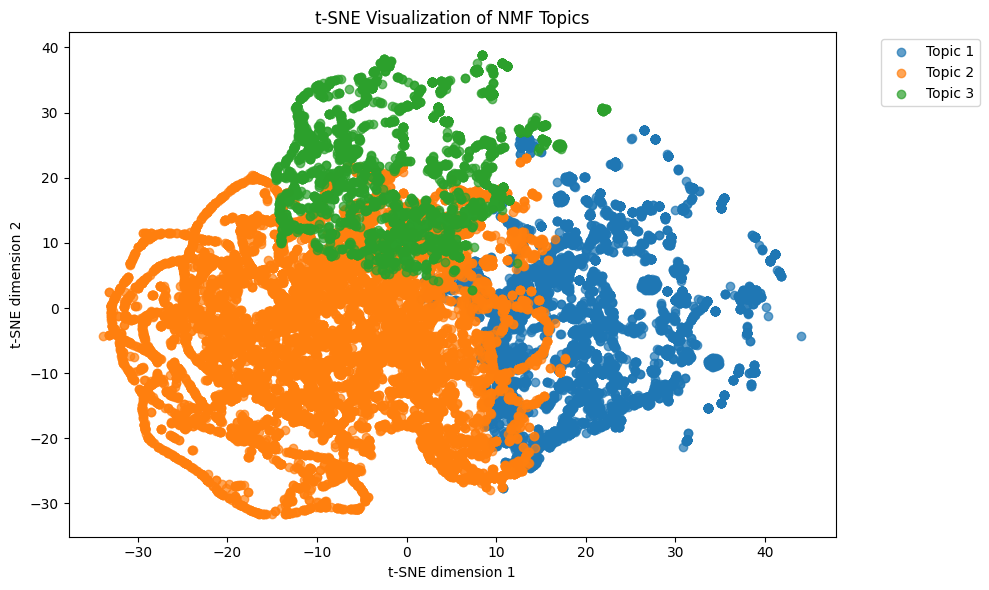

In [71]:
W = best_nmf.transform(tfidf_vectors)

# Apply t-SNE to NMF document-topic matrix
tsne_nmf = TSNE(n_components=best_num_topics, random_state=RANDOM_STATE, perplexity=30)
tsne_nmf_results = tsne_nmf.fit_transform(W)

# Create a figure for the t-SNE visualization of NMF topics
plt.figure(figsize=(10, 6))

# Get the dominant topic for each document from NMF
nmf_dominant_topics = np.argmax(W, axis=1)

# Plot each document colored by its dominant NMF topic
for topic_idx in range(nmf_model.n_components):
    # Get indices of documents with this dominant topic
    indices = np.where(nmf_dominant_topics == topic_idx)[0]
    plt.scatter(
        tsne_nmf_results[indices, 0], 
        tsne_nmf_results[indices, 1],
        label=f'Topic {topic_idx+1}',
        alpha=0.7
    )

plt.title('t-SNE Visualization of NMF Topics')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [72]:
# Print top words for each NMF topic
print("Top words in each NMF topic:")
feature_names = tfidf_vectorizer.get_feature_names_out()
n_top_words = 10  # Number of top words to display for each topic

for topic_idx, topic in enumerate(nmf_model.components_):
    # Get the indices of the top words for this topic
    top_word_indices = topic.argsort()[:-n_top_words-1:-1]
    # Get the actual words
    top_words = [feature_names[i] for i in top_word_indices]
    # Print the topic number and its top words
    print(f"Topic #{topic_idx+1}: {' '.join(top_words)}")


Top words in each NMF topic:
Topic #1: product laptop awesome quality great performance battery price excellent perfect
Topic #2: money value worth penny wonderful laptop buy waste performance wow
Topic #3: nice product wonderful wow worth brilliant super market fabulous penny


In [73]:
# Print top words for each NMF topic
print("Top words in each NMF topic:")
feature_names = tfidf_vectorizer.get_feature_names_out()
n_top_words = 10  # Number of top words to display for each topic

for topic_idx, topic in enumerate(best_nmf.components_):
    # Get the indices of the top words for this topic
    top_word_indices = topic.argsort()[:-n_top_words-1:-1]
    # Get the actual words
    top_words = [feature_names[i] for i in top_word_indices]
    # Print the topic number and its top words
    print(f"Topic #{topic_idx+1}: {' '.join(top_words)}")


Top words in each NMF topic:
Topic #1: nice product classy perfect great quality wonderful super fabulous wow
Topic #2: laptop awesome performance battery terrific purchase price buy excellent display
Topic #3: money value worth penny wonderful product waste buy wow market


In [75]:
# Train BERTopic model
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import numpy as np

print("Training BERTopic model...")

# Load a pre-trained sentence transformer model
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert documents to embeddings
print("Converting documents to embeddings...")
embeddings = sentence_model.encode(docs_bert, show_progress_bar=True)

# Initialize and train BERTopic
# We'll use a lower n_components to make it comparable to our NMF model
bertopic_model = BERTopic(
    embedding_model=sentence_model,
    nr_topics=8,
    min_topic_size=20,
    # random_state=555
)

# Fit the model and transform the documents
topics, probs = bertopic_model.fit_transform(docs_bert, embeddings)

# Get topic information
topic_info = bertopic_model.get_topic_info()
print("\nTopic Information:")
print(topic_info.head(10))

# Visualize the topics
print("\nVisualizing BERTopic model topics...")
fig = bertopic_model.visualize_topics()
fig.update_layout(height=800, width=1200)
fig.show()

# Visualize the topic hierarchy
print("\nVisualizing topic hierarchy...")
fig = bertopic_model.visualize_hierarchy()
fig.update_layout(height=800, width=1200)
fig.show()

# Print top words for each topic
print("\nTop words in each BERTopic topic:")
for topic_id in sorted(list(set(topics)))[1:]:  # Skip -1 which is the outlier topic
    if topic_id != -1:  # Skip outlier topic
        words = bertopic_model.get_topic(topic_id)
        word_list = [word for word, _ in words[:10]]
        print(f"Topic #{topic_id}: {' '.join(word_list)}")

# Compare with NMF topics
print("\nComparing BERTopic with NMF topics...")


Training BERTopic model...
Converting documents to embeddings...


Batches:   0%|          | 0/754 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitl


Topic Information:
   Topic  Count                                               Name  \
0     -1   5858                     -1_good_laptop_battery_product   
1      0  15687                        0_good_product_laptop_money   
2      1   1750                          1_good_nice_awesome_super   
3      2    437                       2_heating_heat_issue_problem   
4      3    157              3_meet_expectation_expect_product_bad   
5      4     98                4_hang_hinge_problem_unsatisfactory   
6      5     76  5_absolute_rubbish_utterly_disappointed_slight...   
7      6     50                     6_average_fair_moderate_degine   

                                      Representation  \
0  [good, laptop, battery, product, performance, ...   
1  [good, product, laptop, money, battery, nice, ...   
2  [good, nice, awesome, super, wonderful, wow, e...   
3  [heating, heat, issue, problem, laptop, fan, b...   
4  [meet_expectation, expect, product, bad, work,...   
5  [hang, hin


Visualizing topic hierarchy...



Top words in each BERTopic topic:
Topic #0: good product laptop money battery nice performance display quality value
Topic #1: good nice awesome super wonderful wow excellent terrific fabulous simply
Topic #2: heating heat issue problem laptop fan battery good noise bad
Topic #3: meet_expectation expect product bad work month meet_expectation_bettery waste hang properly
Topic #4: hang hinge problem unsatisfactory laptop issue close time automatically bad
Topic #5: absolute_rubbish utterly_disappointed slightly_disappointed bad waste slightly asfalt terrible ut disappoint
Topic #6: average fair moderate degine okay vaue money like bad value

Comparing BERTopic with NMF topics...


## Documentation (10 marks) and 15 mins Presentation (10 marks)
Document the entire project, including the dataset description, preprocessing steps, model architecture, hyperparameter settings, and evaluation results.

Create a presentation summarizing the project's objectives, methods, findings, and recommendations.

- First round not good , try to remmove domain specific word.
- try add n-gram